# Гибридная CNN-LSTM модель для прогнозирования временных рядов

- При использовании гибридной модели CNN-LSTM мы разделим каждую выборку на дополнительные подпоследовательности. Модель CNN будет интерпретировать каждую подпоследовательность, а LSTM объединит интерпретации из подпоследовательностей. Мы разделим каждую выборку на 2 подпоследовательности по 2 раза на подпоследовательность.
- CNN будет ожидать 2 временных шага на подпоследовательность с одним признаком. Затем вся модель CNN упаковывается в слои оболочки TimeDistributed, чтобы ее можно было применить к каждой подпоследовательности в выборке. Затем результаты интерпретируются слоем LSTM до того, как модель выдаст прогноз.

In [1]:
%matplotlib inline

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# https://www.kaggle.com/pattnaiksatyajit/network-analytics-time-series
df = pd.read_csv('./data/Network Analytics.csv', index_col=['Timestamp'], parse_dates=['Timestamp'])

In [3]:
df.head()

,OutboundUtilzation (%)
Timestamp,
2017-10-10 07:01:00,96.2442
2017-10-10 07:21:00,99.1131
2017-10-10 07:26:00,97.2892
2017-10-10 07:31:00,98.0286
2017-10-10 07:36:00,99.5263


In [4]:
def hour_smooth(data):
    current_datetime = data.index[1]
    utilization_hour_sum, measurement_count = 0, 0
    result_dict = {}
    for index, row in data.iterrows():
        if index.hour != current_datetime.hour:

            new_tiestamp = pd.Timestamp(year=current_datetime.year, 
                                        month=current_datetime.month, 
                                        day=current_datetime.day, 
                                        hour=current_datetime.hour)
            new_value = utilization_hour_sum / measurement_count
            result_dict[new_tiestamp] = new_value

            current_datetime = index
            utilization_hour_sum = row["OutboundUtilzation (%)"]
            measurement_count = 1
        else:
            utilization_hour_sum += row["OutboundUtilzation (%)"]
            measurement_count += 1
    return pd.DataFrame.from_dict(result_dict, orient="index", columns=["utilization"])

In [5]:
resampled_data = hour_smooth(df)

In [6]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [7]:
normalized_data = normalize(resampled_data)

In [8]:
X = normalized_data['utilization'].to_numpy()

In [9]:
#Разделяем на подпоследовательности
X_ans = []
Y_ans = []
for i in range(len(X)-4):
    x = list(X)[i:i+4]
    y = list(X)[i+4]
    
    X_ans.append(x)
    Y_ans.append(y)

In [10]:
X_util = array(X_ans)
y_util = array(Y_ans)

# 80% на обучение
last_id = int(y_util.shape[0] * 0.8)

X_train = X_util[:last_id]
X_valid  = X_util[last_id:]

In [11]:
# reshape train and valid from [samples, timesteps] into [samples, subsequences, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 2, 2, 1))
y_train = y_util [:last_id]

X_valid = X_valid.reshape((X_valid.shape[0], 2, 2, 1))
y_valid = y_util[last_id:]

In [12]:
# модель
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

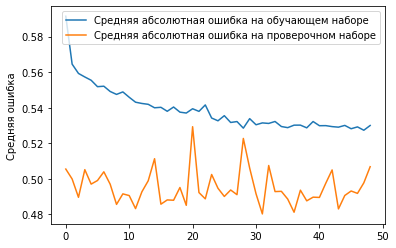

In [13]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

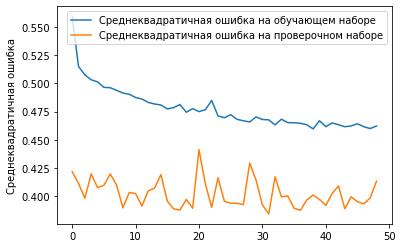

In [14]:
plt.plot(history.history['mse'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

In [15]:
y_pred = model.predict(X_valid)

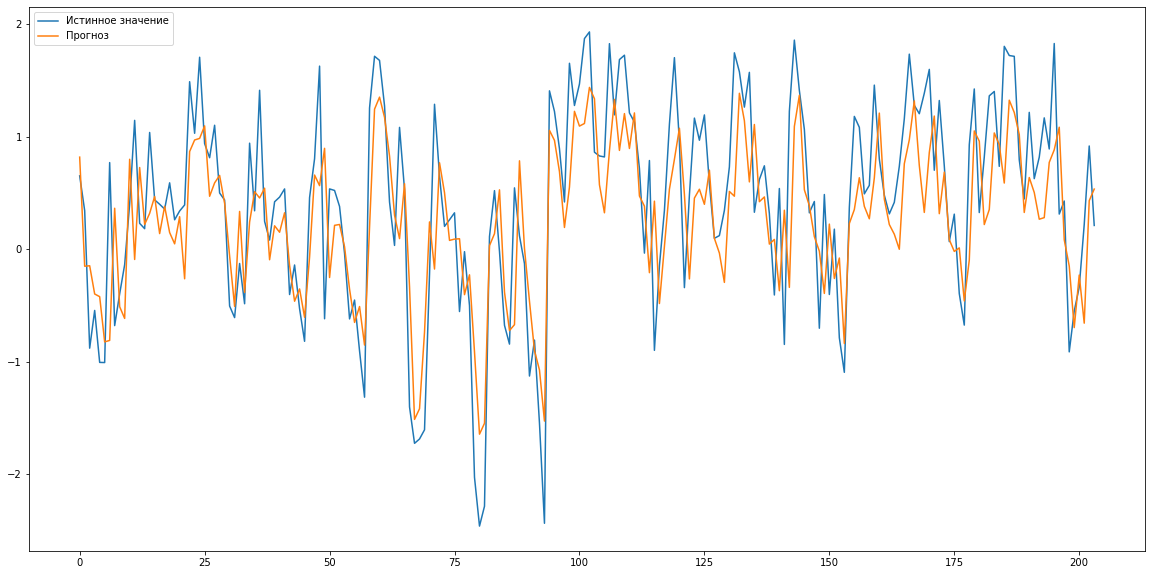

In [16]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid[::2], 
         label='Истинное значение')
plt.plot(y_pred[::2], 
         label='Прогноз')
plt.legend()
plt.show()

Изменим параметры слоев

In [17]:
# модель
model2 = Sequential()

model2.add(TimeDistributed(
    Conv1D(filters=128, kernel_size=1, activation='relu'), 
    input_shape=(None, 2, 1)))

model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model2.add(TimeDistributed(Flatten()))

model2.add(LSTM(128, activation='relu'))

model2.add(Dense(1, activation="linear"))

model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model2.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

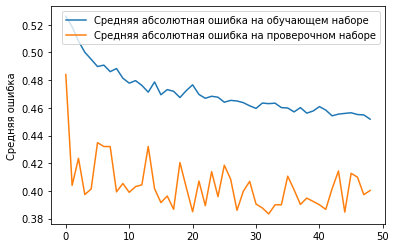

In [18]:
plt.plot(history.history['mse'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

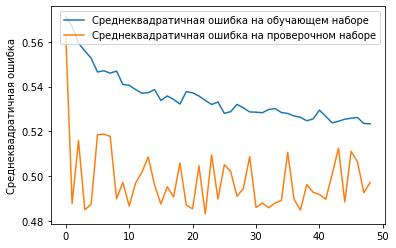

In [19]:
plt.plot(history.history['mae'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

Ошибки уменьшились, но по-прежнему ведут себя нестабильно, особенно на валидационном наборе

Добавим полносвязных слоев

In [20]:
# модель
model3 = Sequential()

model3.add(TimeDistributed(
    Conv1D(filters=128, kernel_size=1, activation='relu'), 
    input_shape=(None, 2, 1)))

model3.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model3.add(TimeDistributed(Flatten()))

model3.add(LSTM(128, activation='relu'))

model3.add(Dense(64, activation="relu"))
model3.add(Dense(64, activation="relu"))

model3.add(Dense(1, activation="linear"))

model3.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model3.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

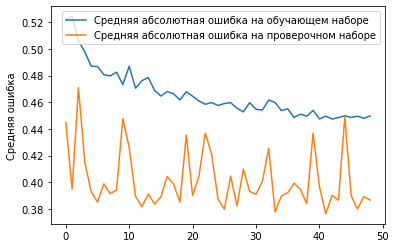

In [21]:
plt.plot(history.history['mse'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

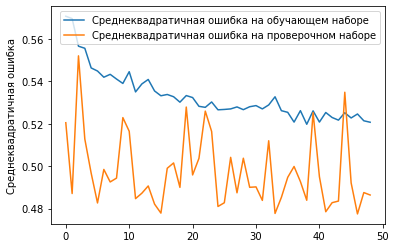

In [22]:
plt.plot(history.history['mae'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

Ошибка ведет себя еще более нестабильно

In [23]:
y_pred = model2.predict(X_valid)

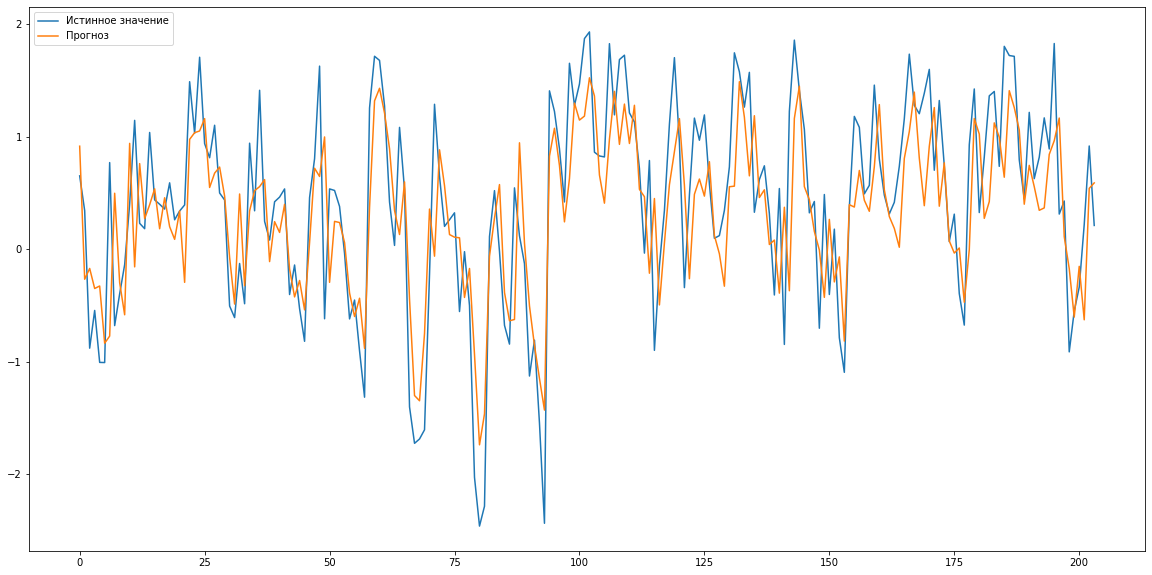

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid[::2], 
         label='Истинное значение')
plt.plot(y_pred[::2], 
         label='Прогноз')
plt.legend()
plt.show()

### Попробуем другой датасет

In [25]:
# https://www.kaggle.com/jamieleech/daily-total-female-births
df = pd.read_csv('./data/daily-total-female-births.csv', index_col=['Date'], parse_dates=['Date'])

In [26]:
df.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [27]:
normalized_data = normalize(df)

In [28]:
X = normalized_data['Births'].to_numpy()

In [29]:
#Разделяем на подпоследовательности
X_ans = []
Y_ans = []
for i in range(len(X)-4):
    x = list(X)[i:i+4]
    y = list(X)[i+4]
    
    X_ans.append(x)
    Y_ans.append(y)

In [30]:
X_util = array(X_ans)
y_util = array(Y_ans)

# 80% на обучение
last_id = int(y_util.shape[0] * 0.8)

X_train = X_util[:last_id]
X_valid  = X_util[last_id:]

In [31]:
# reshape train and valid from [samples, timesteps] into [samples, subsequences, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 2, 2, 1))
y_train = y_util [:last_id]

X_valid = X_valid.reshape((X_valid.shape[0], 2, 2, 1))
y_valid = y_util[last_id:]

In [32]:
# модель
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

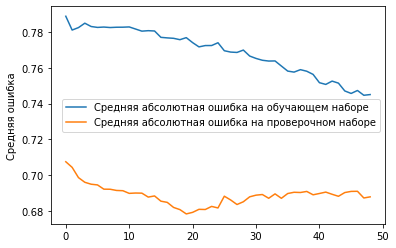

In [33]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

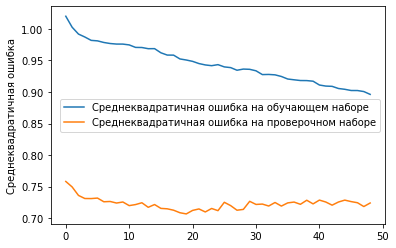

In [34]:
plt.plot(history.history['mse'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

В данном случае ошибка ведет себя значительно более стаббильно, однако кажется, чт начинает расти на валидационном датасете, проверим...

In [35]:
# модель
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=200, verbose=0)

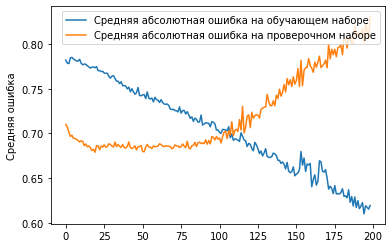

In [36]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

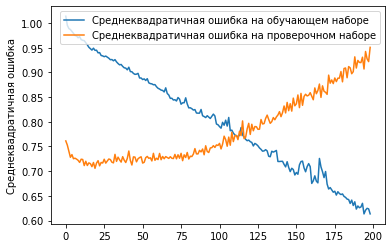

In [37]:
plt.plot(history.history['mse'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

Так и есть, поэтому нужно, ограничится ~20 эпохами

Изменим параметры словев

In [38]:
# модель
model2 = Sequential()

model2.add(TimeDistributed(
    Conv1D(filters=128, kernel_size=1, activation='relu'), 
    input_shape=(None, 2, 1)))

model2.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model2.add(TimeDistributed(Flatten()))

model2.add(LSTM(128, activation='relu'))

model2.add(Dense(1, activation="linear"))

model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

history = model2.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

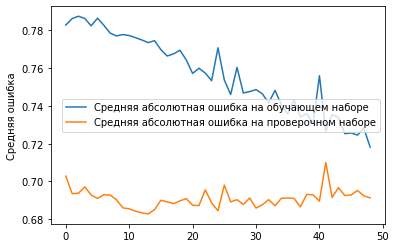

In [39]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

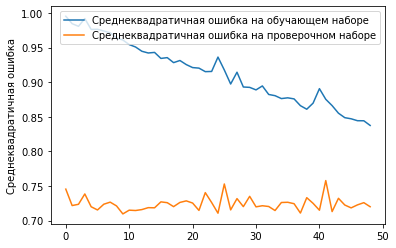

In [40]:
plt.plot(history.history['mse'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

Ошибка не уменьшилась, но стала менее стабильной

Добавим полносвязных слоев

In [41]:
# модель
model3 = Sequential()

model3.add(TimeDistributed(
    Conv1D(filters=128, kernel_size=1, activation='relu'), 
    input_shape=(None, 2, 1)))

model3.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model3.add(TimeDistributed(Flatten()))

model3.add(LSTM(128, activation='relu'))

model3.add(Dense(64, activation="relu"))
model3.add(Dense(64, activation="relu"))

model3.add(Dense(1, activation="linear"))

model3.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model3.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=50, verbose=0)

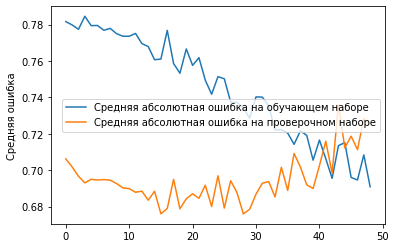

In [42]:
plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

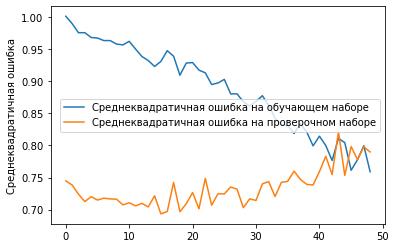

In [43]:
plt.plot(history.history['mse'][1:], 
         label='Среднеквадратичная ошибка на обучающем наборе')
plt.plot(history.history['val_mse'][1:], 
         label='Среднеквадратичная ошибка на проверочном наборе')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

Стало еще хуже, возьмем исходную модель с меньшим количеством эпох

In [44]:
# модель
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=20, verbose=0)

In [45]:
y_pred = model.predict(X_valid)

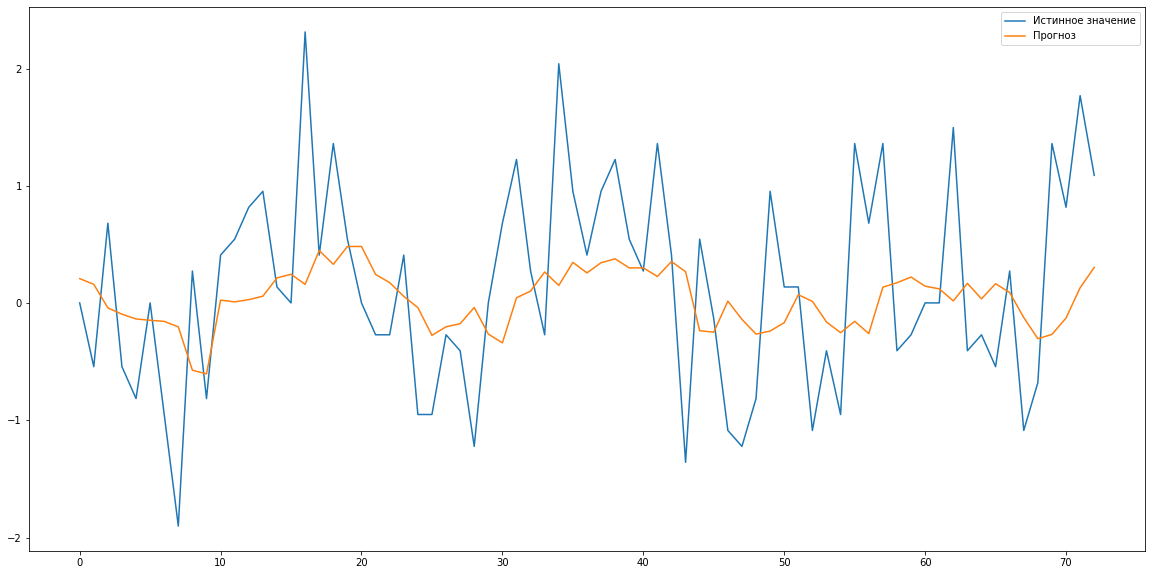

In [46]:
plt.figure(figsize=(20, 10))
plt.plot(y_valid, 
         label='Истинное значение')
plt.plot(y_pred, 
         label='Прогноз')
plt.legend()
plt.show()

По-моему, весьма посредственно....

Я бы не сказал, что данная модель революционно превосходит чистый LTSM, но на первом датасете получилось немного уменьшить ошибку, по сравнению с простым LTSN